In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn_pandas import DataFrameMapper 

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import PCHazard
from pycox.evaluation import EvalSurv

In [2]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [3]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready.xlsx")

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [4]:
df_train.head()

,Age,Grading,Histology,Type,Status,MonthSurvive,YearSurvive
1,17.0,9.0,Undifferentiated,type_2,1.0,1,1
2,55.0,9.0,Serous carcinoma,type_2,1.0,0,1
3,68.0,9.0,Non-specific,Non-specific,1.0,0,1
4,66.0,9.0,Clear cell carcinoma,type_1,1.0,0,1
5,72.0,9.0,Serous carcinoma,type_2,1.0,0,1


In [5]:
# Feature transformers

cols_standardize = ['Age']
cols_onehotencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

#encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + onehot_encoded)

In [6]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [7]:
# label transforms

num_durations = 10
labtrans = PCHazard.label_transform(num_durations)
get_target = lambda df: (df['MonthSurvive'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

C:\ProgramData\Anaconda3\lib\site-packages\pycox\preprocessing\label_transforms.py:219: UserWarning: Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.
  warnings.warn("""Got event/censoring at start time. Should be removed! It is set s.t. it has no contribution to loss.""")


In [8]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransPCHazard

In [10]:
# neural Net

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [11]:
model = PCHazard(net, tt.optim.Adam, duration_index=labtrans.cuts)

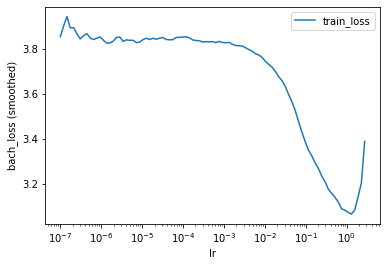

In [12]:
batch_size = 256
lr_finder = model.lr_finder(x_train, y_train, batch_size, tolerance=8)
_ = lr_finder.plot()


In [13]:
lr_finder.get_best_lr()

0.12915496650148922

In [14]:
model.optimizer.set_lr(0.01)

In [15]:
epochs = 100
callbacks = [tt.callbacks.EarlyStopping()]
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.5203,	val_loss: 3.2483
1:	[0s / 0s],		train_loss: 2.9767,	val_loss: 2.7528
2:	[0s / 0s],		train_loss: 2.4947,	val_loss: 2.0948
3:	[0s / 0s],		train_loss: 1.9627,	val_loss: 1.7150
4:	[0s / 0s],		train_loss: 1.6256,	val_loss: 1.6092
5:	[0s / 0s],		train_loss: 1.5432,	val_loss: 1.6430
6:	[0s / 0s],		train_loss: 1.5412,	val_loss: 1.6179
7:	[0s / 0s],		train_loss: 1.5075,	val_loss: 1.5934
8:	[0s / 0s],		train_loss: 1.4951,	val_loss: 1.5769
9:	[0s / 0s],		train_loss: 1.5018,	val_loss: 1.5762
10:	[0s / 0s],		train_loss: 1.4867,	val_loss: 1.5789
11:	[0s / 0s],		train_loss: 1.4874,	val_loss: 1.5776
12:	[0s / 0s],		train_loss: 1.4706,	val_loss: 1.5770
13:	[0s / 0s],		train_loss: 1.4680,	val_loss: 1.5765
14:	[0s / 0s],		train_loss: 1.4724,	val_loss: 1.5821
15:	[0s / 0s],		train_loss: 1.4607,	val_loss: 1.5903
16:	[0s / 0s],		train_loss: 1.4555,	val_loss: 1.5935
17:	[0s / 0s],		train_loss: 1.4590,	val_loss: 1.5934
18:	[0s / 0s],		train_loss: 1.4502,	val_loss: 1.5925
19:

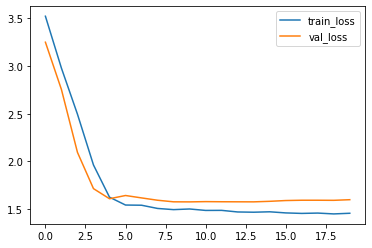

In [16]:
_ = log.plot()

In [17]:
# prediction

surv = model.predict_surv_df(x_test)

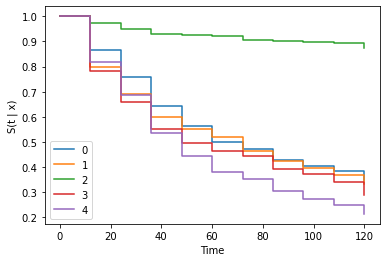

In [18]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [19]:
model.sub = 10

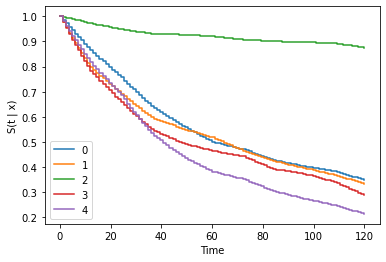

In [20]:
surv = model.predict_surv_df(x_test)
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [21]:
# evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [22]:
ev.concordance_td('antolini')

0.542753992131451

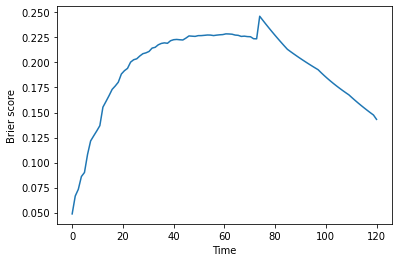

In [23]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

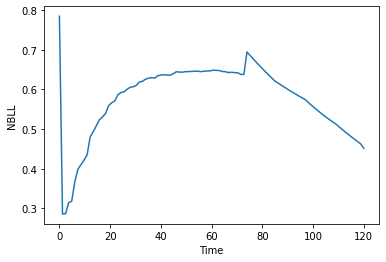

In [24]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [25]:
ev.integrated_brier_score(time_grid) 

0.19456460722181734

In [26]:
ev.integrated_nbll(time_grid) 

0.5751569694781372